In [1]:
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2023-07-23 12:32:06.150248: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# We are working with the Reuters dataset, a set of short newswires and their topics. This will be a single-label, multiclass classification where we classfify Reuters newswire into 46 mutually exclusive topics

In [2]:
# Loading the Reuters dataset
from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words = 10000)

2110848/2110848 [==============================] - 1s 0us/step


In [4]:
# 8,982 training examples and 2,246 testing examples
print(len(train_data))
print(len(test_data))

8982
2246


In [5]:
train_data[10]

[1,
 245,
 273,
 207,
 156,
 53,
 74,
 160,
 26,
 14,
 46,
 296,
 26,
 39,
 74,
 2979,
 3554,
 14,
 46,
 4689,
 4329,
 86,
 61,
 3499,
 4795,
 14,
 61,
 451,
 4329,
 17,
 12]

In [26]:
train_labels[8981]

25

In [16]:
#Decoding newswires back to text
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

In [17]:
decoded_newswire

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

# Encoding the data

In [28]:
def vectorize_sequences(sequences, dimension = 10000):
    results = np.zeros((len(sequences), dimension)) #this creates an all-zero matrix of shape (len(sequences),
    # dimension)
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1 # sets specific indices of results[i] to 1s
    return results

x_train = vectorize_sequences(train_data) # vectorized training data
x_test = vectorize_sequences(test_data) # vectorized test data

# multiple ways to vectorize labels but One-hot encoding is the common method for categorical data

from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)


In [31]:
one_hot_train_labels[1]

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

# Model Definition

In [35]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape = (10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax')) 

# The network ends with a Dense layer of size 46. This means for each input sample, the network will output a 46
# dimensional vector. Each entry in this vector (each dimenstion) will encode a different output class

# last layer uses a softmax activation. This means that the network will output a probability distribution output
# vector, where output[i] is the probability that the sample belongs to class i. The 46 scores will sum to 1.


In [36]:
# Compiling the model

model.compile(optimizer = 'rmsprop',
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

# Validating the approach (Making validation set and training the model)

In [37]:
# Setting aside a validation set
x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

In [40]:
#Training the model
history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs = 20,
                   batch_size = 512,
                   validation_data = (x_val, y_val))

Epoch 1/20
16/16 [==============================] - 1s 35ms/step - loss: 2.7052 - accuracy: 0.4873 - val_loss: 1.7513 - val_accuracy: 0.6220
Epoch 2/20
16/16 [==============================] - 0s 16ms/step - loss: 1.4287 - accuracy: 0.7070 - val_loss: 1.3116 - val_accuracy: 0.7160
Epoch 3/20
16/16 [==============================] - 0s 17ms/step - loss: 1.0600 - accuracy: 0.7746 - val_loss: 1.1349 - val_accuracy: 0.7490
Epoch 4/20
16/16 [==============================] - 0s 18ms/step - loss: 0.8347 - accuracy: 0.8188 - val_loss: 1.0295 - val_accuracy: 0.7860
Epoch 5/20
16/16 [==============================] - 0s 18ms/step - loss: 0.6652 - accuracy: 0.8598 - val_loss: 0.9877 - val_accuracy: 0.7830
Epoch 6/20
16/16 [==============================] - 0s 18ms/step - loss: 0.5331 - accuracy: 0.8906 - val_loss: 0.9941 - val_accuracy: 0.7740
Epoch 7/20
16/16 [==============================] - 0s 17ms/step - loss: 0.4340 - accuracy: 0.9109 - val_loss: 0.8974 - val_accuracy: 0.8040
Epoch 8/20
16

<function matplotlib.pyplot.show(close=None, block=None)>

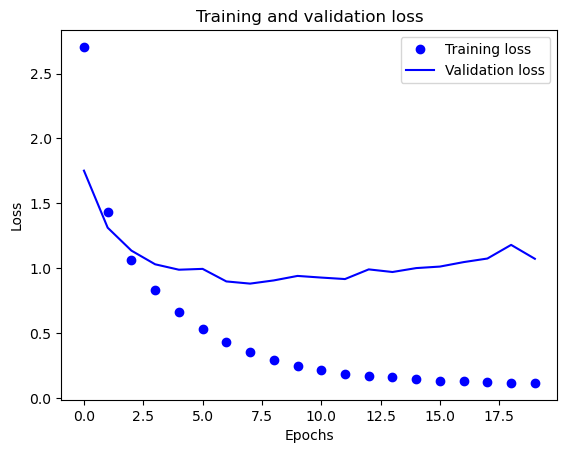

In [41]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(20)

plt.plot(epochs, loss_values, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss_values, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

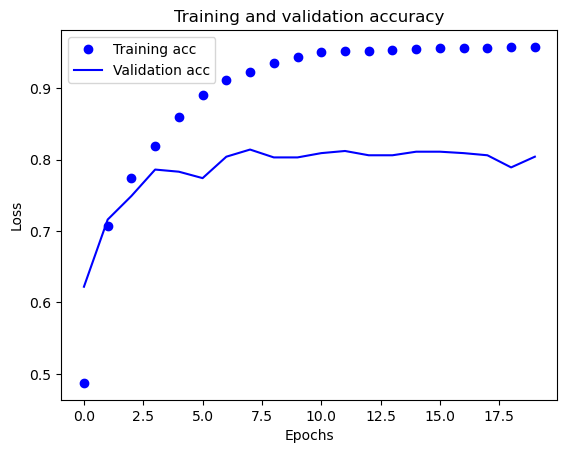

In [44]:
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

plt.plot(epochs, acc_values, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc_values, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show

# Retraining the Model with 9 Epochs due to Overfitting

In [45]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape = (10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax')) 

# Compiling the model

model.compile(optimizer = 'rmsprop',
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

#Traing the Model

history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs = 20,
                   batch_size = 512,
                   validation_data = (x_val, y_val))

#Evaluation based on test set
results = model.evaluate(x_test, one_hot_test_labels)

Epoch 1/20
16/16 [==============================] - 1s 34ms/step - loss: 2.7039 - accuracy: 0.5406 - val_loss: 1.7528 - val_accuracy: 0.6410
Epoch 2/20
16/16 [==============================] - 0s 19ms/step - loss: 1.4340 - accuracy: 0.6999 - val_loss: 1.3227 - val_accuracy: 0.7230
Epoch 3/20
16/16 [==============================] - 0s 18ms/step - loss: 1.0801 - accuracy: 0.7662 - val_loss: 1.1617 - val_accuracy: 0.7420
Epoch 4/20
16/16 [==============================] - 0s 17ms/step - loss: 0.8599 - accuracy: 0.8109 - val_loss: 1.0498 - val_accuracy: 0.7800
Epoch 5/20
16/16 [==============================] - 0s 16ms/step - loss: 0.6976 - accuracy: 0.8474 - val_loss: 0.9866 - val_accuracy: 0.7870
Epoch 6/20
16/16 [==============================] - 0s 19ms/step - loss: 0.5563 - accuracy: 0.8815 - val_loss: 0.9514 - val_accuracy: 0.8010
Epoch 7/20
16/16 [==============================] - 0s 18ms/step - loss: 0.4533 - accuracy: 0.9045 - val_loss: 0.9217 - val_accuracy: 0.8010
Epoch 8/20
16

In [49]:
results

[1.1836967468261719, 0.7894033789634705]

In [51]:
import copy
test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
hits_array = np.array(test_labels) == np.array(test_labels_copy)
float(np.sum(hits_array))/len(test_labels_copy)

0.19768477292965272

In [ ]:
# This approach reaches an accuracy of ~80%. With a balanced binary classification problem, the accuracy reached
# by a purely random classifier would be 50%. But in this case it's closer to 19%, so the results seem pretty good,
# at least when compared to a random baseline


# Generating predictions on new data

In [57]:
predictions = model.predict(x_test)

71/71 [==============================] - 0s 1ms/step


In [58]:
# Each entry in predictions is a vector of length 46
predictions[0].shape

(46,)

In [59]:
#the coefficients in this vector sum to 1
np.sum(predictions[0])

1.0

In [60]:
#the largest entry in the predicited class - the class with the highest probability:
np.argmax(predictions[0])

3

# Takeaways

In [61]:
# For problems with multiple different classes it is important to construct a neural network with large
# dimensionality. That is why 64 units were instead of 16 for example

# avoid intermediate layers with fewer than 46 hidden units if there are 46 classes

# if you are trying to classify data points among N classes, your network should end with dense layer of size N

# In a single label, multiclass classification problem, your network should end with with a softmax activation

# categorical cross entropy is almost always the loss function you should use for such problems. 